# Comparison of lens curvature measurements 
- Anastasia measured the radius of curvature for the 29 lenses of the right eye. 
    - **NOTE**: The lens was damaged in six ommatidia of specimen 1: C4, D4, D6, D7, E5, E7 (n=23). AM replaced measurements of thickness, curvature, lens, diameter, cone length and width from another specimen. 
- Jing Peng measured radius of curvature for each lens by fitting circles on a prob map from Ilastik px classification.
    - For his first attempt, he accidentally did this on the wrong (Left) eye. All the lenses of the left eye were intact in the EM data (hence n=29).
    - Measurements were performed on the other (right) eye in May 2021. For the right eye, JP excluded the same set of ommatidia as Anastasia, in addition to C6 (hence n=22). JP also measured the minimum distance between the inner surface of the lens and the rhabdom. 
 
1. Compare measurements obtained by Anastasia and Jing Peng
2. Compare optics of the left and right eyes 

In [1]:
import math
import numpy as np
import os.path
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import statsmodels.api as sm

from src.utils import index_by_om
from src.dataframe_tools import assemble_cxvectors
from vis.fig_tools import linear_cmap, subtype_cm
from vis.hex_lattice import hexplot_TEST, hexplot

In [83]:
plt.rcdefaults()
#plt.style.use('vis/lamina.mplstyle')
### SAVE FIGS? ###
save_figs=False
##################
# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.png')

def om_group_color(om: str):
    if om in ['A5', 'A4', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']:
        return 'darkviolet'
    else:
        return 'darkgreen'

In [84]:
am_df = pd.read_excel('~/Data/data for ligh prop.xlsx', index_col=0)
am_df = am_df.iloc[:29] # remove last two lines of excel file
# Add pre-computed rhabdom lengths (from rhabdomere_lengths.ipynb)
rh_len = pd.read_pickle('~/Dropbox/Data/201123_rh_len_df.pickle')
for i, v in rh_len.iterrows():
    am_df.loc[i, 'rhabdom_len'] = float(v)
display(am_df)

<ipython-input-84-e4690d5b8895>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  am_df = pd.read_excel('~/Data/data for ligh prop.xlsx', index_col=0)


,facet diameter (stack),lense thickness,outer curvature,inner curvature,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,rhabdom_len
E7,6.923,2.60900,2.219000,1.059000,3.26300,4.630000,1.782745,1.247685,13.960
E6,6.98073,2.96461,3.075507,1.506532,3.40063,5.523305,2.262045,1.454785,13.352
E5,9.263,3.64300,3.818000,2.765000,4.94300,6.648000,2.417245,2.116145,11.088
E4,8.07757,2.65285,4.636710,3.762965,3.67528,6.701025,2.970095,2.274005,12.704
D7,6.396,2.15800,2.969000,0.926000,2.82000,4.681000,1.917540,1.261355,14.032
D6,7.234,2.52200,3.042000,1.363000,2.86938,4.580985,1.980355,1.238485,13.976
D5,8.16472,3.58905,4.107682,2.415439,3.73574,6.450405,2.444485,2.152785,13.520
D4,8.028,3.83100,4.619000,2.510000,5.29000,6.910000,2.918445,2.018030,13.792
D3,7.2377,2.80608,5.070646,3.926605,3.96908,6.664940,2.949440,2.042290,14.640
D2,7.33428,2.86169,5.445023,3.446124,3.75099,6.633140,2.968950,2.206545,13.760


In [85]:
# Load Jing Peng's measurements for lens interal/external center coords and curvature
with open(os.path.expanduser('~/Data/210521_jp_optics_measurements.json')) as fh:
    jp_data = json.load(fh)
jp_df = pd.DataFrame(jp_data)

# Convert JP's radii of curvature / distances from nm to microns
jp_df[['radii_in', 'radii_out', 'distances']] = jp_df[['radii_in', 'radii_out', 'distances']] / 1000.0
# Compute lens thickness with internal/external center coordinates
distances = lambda p1, p2: np.linalg.norm(p1 - p2)
lens_thickness = [] 
for p1, p2 in zip(jp_df['centers_in'], jp_df['centers_out']):
    lens_thickness.append(distance(np.array(p1), np.array(p2)) / 1000.0)
jp_df['lens_thickness'] = lens_thickness

display(jp_df.head())

,centers_in,centers_out,radii_in,radii_out,distances,lens_thickness
1,"[44865.20256768055, 6823.465129920077, 71421.5...","[43701.4964323663, 8394.95778302243, 71304.161...",1.436002,2.525935,2.615951,1.958977
2,"[50678.925094593986, 14231.057629020284, 75101...","[47421.43886995598, 16347.624544109902, 73955....",2.759870,4.533598,4.079285,4.050188
3,"[37161.55344438691, 2844.644458627794, 73051.6...","[36728.25454027133, 4859.546197612293, 72786.9...",1.412395,2.262617,2.937753,2.077892
4,"[53267.795220007334, 23196.107428086852, 78140...","[49341.32540772697, 24384.421568839673, 77048....",2.774426,5.038673,4.188894,4.245302
5,"[28310.82508579014, 3041.570652780094, 76475.9...","[28089.39304085308, 4954.348577994009, 75848.1...",1.594241,2.235906,2.629988,2.025294


In [86]:
#### LABEL JP'S MEASUREMENTS AS OMMATIDIA COORDINATES ####
### RIGHT EYE ###
right_om_labels = {'A0': 73, 'B0': 72, 
                  'A1': 71, 'B1': 70, 'C1': 69, 
                  'A2': 68, 'B2': 67, 'C2': 66, 'D2': 65, 
                  'A3': 68, 'B3': 63, 'C3': 61, 'D3': 62, 
                  'A4': 60, 'B4': 57, 'E4': 59,  
                  'A5': 56, 'B5': 55, 'C5': 54, 'D5': 53,
                  'B6': 52, 'E6': 51}

right_inverted = {str(v): k for k, v in right_om_labels.items()}
right_indices = [str(v) for k, v in right_om_labels.items()]
jp_right = jp_df.loc[right_indices]
jp_right = jp_right.rename(index=right_inverted)
# Re-order Anastasia's data to match JP's right eye measurements
# Remove c6 (excluded in JP's measurements)
am_right = am_df.loc[jp_right.index]

### LEFT EYE ###
left_om_labels = {'A0': 12, 'B0': 19, 
             'A1': 11, 'B1': 21, 'C1': 26,
             'A2': 7, 'B2': 17, 'C2': 24, 'D2': 28, 
             'A3': 4, 'B3': 15, 'C3': 23, 'D3': 29, 
             'A4': 2, 'B4': 10, 'C4': 18, 'D4': 25, 'E4': 27, 
             'A5': 1, 'B5': 6, 'C5': 14, 'D5': 20, 'E5': 22, 
             'B6': 3, 'C6': 9, 'D6': 13, 'E6': 16, 
             'D7': 5, 'E7': 8}

left_inverted = {str(v): k for k, v in left_om_labels.items()}
left_indices = [str(v) for k, v in left_om_labels.items()]
jp_left = jp_df.loc[left_indices]
jp_left = jp_left.rename(index=left_inverted)

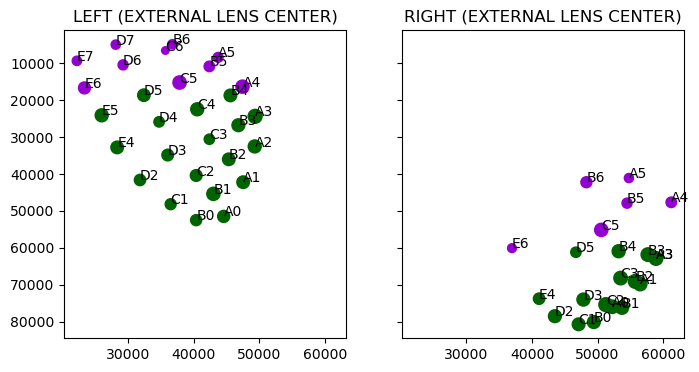

In [87]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], sharex=True, sharey=True)


x = [c[0] for c in jp_left['centers_out']]
y = [c[1] for c in jp_left['centers_out']]
ax[0].scatter(x, y, s=jp_left['radii_out'] * 20.0, c=[om_group_color(om) for om in jp_left.index])
for i, row in jp_left.iterrows():
    ax[0].annotate(i, (row['centers_out'][0], row['centers_out'][1]))
#     ax[0, 1].scatter(inter[1], inter[2])
#     ax[0, 2].scatter(inter[0], inter[2])
x = [c[0] for c in jp_right['centers_out']]
y = [c[1] for c in jp_right['centers_out']]
ax[1].scatter(x, y, s=jp_right['radii_out'] * 20.0, c=[om_group_color(om) for om in jp_right.index])
for i, row in jp_right.iterrows():
    ax[1].annotate(i, (row['centers_out'][0], row['centers_out'][1]))
#     ax[1, 1].scatter(inter[1], inter[2])
#     ax[1, 2].scatter(inter[0], inter[2])
    
ax[0].set_title('LEFT (EXTERNAL LENS CENTER)')
ax[1].set_title('RIGHT (EXTERNAL LENS CENTER)')
plt.gca().invert_yaxis()
    
plt.show()

## Right eye: AM vs JP lens curvature measurements

Text(0.5, 1.0, 'Inner radius of curvature (n=22)')

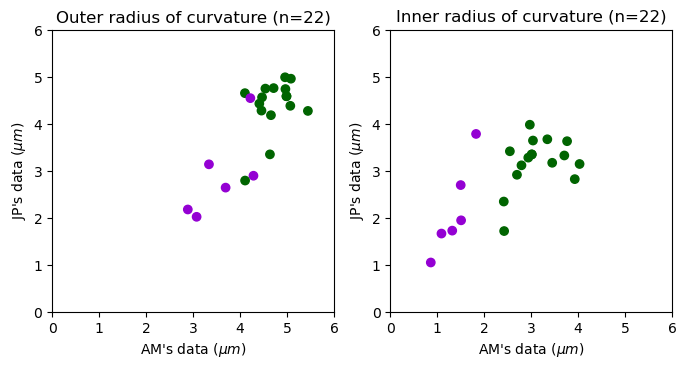

In [88]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

x = am_right.loc[:, 'outer curvature']
y = jp_right.loc[:, 'radii_out']
assert(all([i == j for i, j in zip(am_right.index, jp_right.index)]))
group_c = [om_group_color(c) for c in am_right.index]
ax[0].scatter(x, y, c=group_c)
ax[0].set_xlim([0.0, 6.0])
ax[0].set_ylim([0.0, 6.0])
ax[0].set_xlabel(r"AM's data ($\mu m$)")
ax[0].set_ylabel(r"JP's data ($\mu m$)")
ax[0].set_aspect('equal')
ax[0].set_title(f'Outer radius of curvature (n={len(x)})')


x = am_right.loc[:, 'inner curvature']
y = jp_right.loc[:, 'radii_in']
ax[1].scatter(x, y, c=group_c)
ax[1].set_xlim([0.0, 6.0])
ax[1].set_ylim([0.0, 6.0])
ax[1].set_xlabel(r"AM's data ($\mu m$)")
ax[1].set_ylabel(r"JP's data ($\mu m$)")
ax[1].set_aspect('equal')
ax[1].set_title(f'Inner radius of curvature (n={len(x)})')



In [138]:
display(am_right['outer curvature'])
display(jp_right['radii_out'])

A0    4.104361
B0    4.456473
A1    4.539853
B1    4.468678
C1    4.658214
A3    4.989014
B2    5.082763
C2    4.959154
D2    5.445023
A3    4.989014
B3    4.715047
C3    4.966403
D3    5.070646
A4    4.285955
B4    4.410941
E4    4.636710
A5    2.888274
B5    3.692992
C5    4.219751
D5    4.107682
B6    3.338393
E6    3.075507
Name: outer curvature, dtype: float64

A0    4.653592
B0    4.281909
A1    4.750297
B1    4.565100
C1    4.184439
A3    4.587835
B2    4.961245
C2    4.991327
D2    4.275189
A3    4.587835
B3    4.760887
C3    4.740711
D3    4.383915
A4    2.895273
B4    4.430409
E4    3.350345
A5    2.176745
B5    2.642230
C5    4.547252
D5    2.792726
B6    3.138212
E6    2.020725
Name: radii_out, dtype: float64

Ommatidia with the largest diff between AM and JP:
- A4 Outer curvature: A4's outer lens surface looks like it has similar radius of curvature to A3 and B3. In JP's data, A4 has a very small radius of curvature compared to A3 and B3, while AM's A4 is very close. AM looks more correct
- D5 Outer curvature: D5 

B4    0.019468
C2    0.032173
B3    0.045840
B1    0.096422
B2    0.121518
B0    0.174564
B6    0.200181
A1    0.210444
C3    0.225692
C5    0.327501
A3    0.401179
A3    0.401179
C1    0.473775
A0    0.549231
D3    0.686731
A5    0.711529
B5    1.050762
E6    1.054782
D2    1.169834
E4    1.286365
D5    1.314956
A4    1.390682
dtype: float64

facet diameter (stack)               8.63279
lense thickness                       3.4866
outer curvature                     4.285955
inner curvature                     1.825086
cone length (from the tip)           3.61063
cone width (under the lense tip)    5.875145
D rhabdom dist.                      2.14128
D rhabdom prox.                     1.505155
rhabdom_len                           12.096
Name: A4, dtype: object

centers_in        [58140.19346565717, 48188.35016590987, 14541.8...
centers_out       [61239.3386833, 47677.01812569167, 13518.65489...
radii_in                                                   3.785192
radii_out                                                  2.895273
distances                                                  3.571274
lens_thickness                                             3.303503
Name: A4, dtype: object

D5    0.069622
E4    0.132228
B6    0.186862
B1    0.219759
D2    0.275138
B3    0.325063
C1    0.329101
A3    0.337624
A3    0.337624
A1    0.343759
C3    0.377734
B5    0.408309
E6    0.439402
A5    0.575798
B0    0.607945
B4    0.705155
B2    0.871283
C2    0.883903
A0    1.011082
D3    1.103675
C5    1.198109
A4    1.960106
dtype: float64

Text(0.5, 0, 'RIGHT EYE: AM - JP ($\\mu m$)')

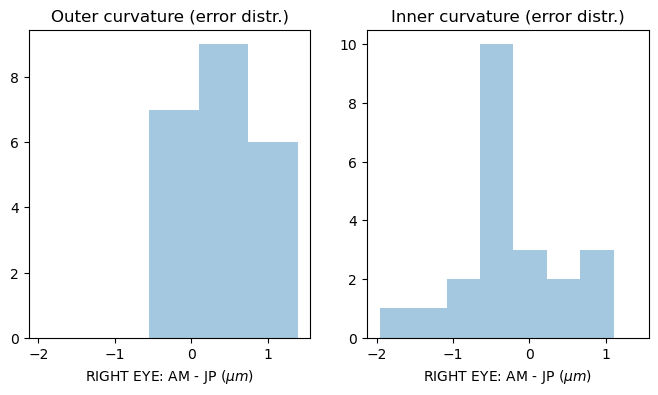

In [139]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], sharex=True)

x = am_right.loc[:, 'outer curvature']
y = jp_right.loc[:, 'radii_out']
err = x-y
display(abs(err).sort_values())
sns.distplot(err, ax=ax[0], kde=False)
ax[0].set_title('Outer curvature (error distr.)')
ax[0].set_xlabel('RIGHT EYE: AM - JP ($\mu m$)')

display(am_right.loc['A4'])
display(jp_right.loc['A4'])

x = am_right.loc[:, 'inner curvature']
y = jp_right.loc[:, 'radii_in']
err = x-y
display(abs(err).sort_values())
sns.distplot(err, ax=ax[1], kde=False)
ax[1].set_title('Inner curvature (error distr.)')
ax[1].set_xlabel('RIGHT EYE: AM - JP ($\mu m$)')



## Right eye: AM vs JP focal length and cone length

Text(0, 0.5, "JP's 'CONE LENGTH' $(\\mu m)$")

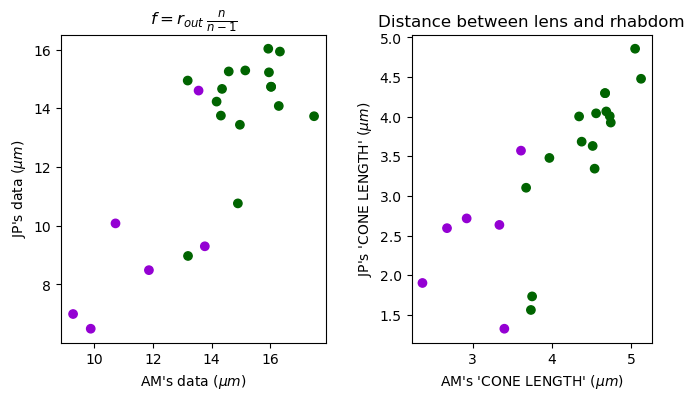

In [90]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

# Focal length
n = 1.452 # Refraction index of Apis lens 
f_thin = lambda r_outer: r_outer * n / (n-1)
f_am = f_thin(am_right.loc[:, 'outer curvature'])
f_jp = f_thin(jp_right.loc[:, 'radii_out'])

ax[0].scatter(f_am, f_jp, c=group_c)
ax[0].set_aspect('equal')
ax[0].set_title(r"$f = r_{out}\:\frac{n}{n-1}$")
ax[0].set_xlabel(r"AM's data $(\mu m)$")
ax[0].set_ylabel(f"JP's data $(\mu m)$")

# Distance between lens and rhabdom
dist_am = am_right.loc[:, 'cone length (from the tip)']
dist_jp = jp_right.loc[:, 'distances']
ax[1].scatter(dist_am, dist_jp, c=group_c)
ax[1].set_aspect('equal')
ax[1].set_title(r"Distance between lens and rhabdom")
ax[1].set_xlabel(r"AM's 'CONE LENGTH' $(\mu m)$")
ax[1].set_ylabel(f"JP's 'CONE LENGTH' $(\mu m)$")


In [129]:
err = am_right['cone length (from the tip)'] - jp_right['distances']

err.sort_values()


A4    0.039356
B6    0.083783
B0    0.193287
A5    0.208843
C2    0.341023
A3    0.374605
A3    0.374605
B5    0.465877
D3    0.489869
A1    0.516272
E4    0.572181
A0    0.620846
C1    0.647640
B3    0.691656
C5    0.704054
B1    0.723539
B2    0.818110
B4    0.884748
C3    1.196044
D2    2.019012
E6    2.076507
D5    2.174934
dtype: float64

## LEFT VS RIGHT

In [114]:
## FOR LEFT RIGHT COMPARISONS, GET RID OF OMMATIDIA EXCLUDED IN RIGHT EYE
jp_left_in_r = jp_left.loc[jp_right.index]

Text(0.5, 1.0, 'Inner radius of curvature (n=22)')

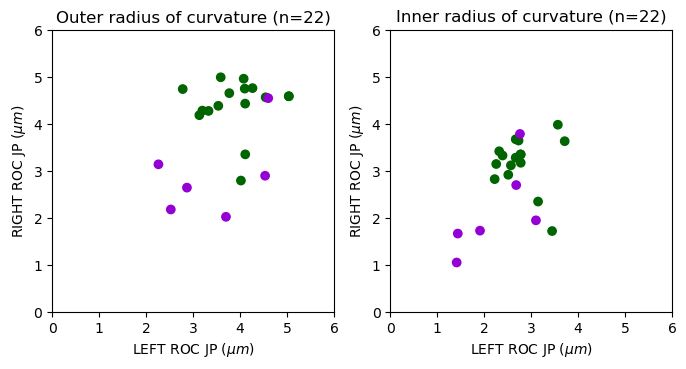

In [115]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

x = jp_left_in_r.loc[:, 'radii_out']
y = jp_right.loc[:, 'radii_out']
assert(all([i == j for i, j in zip(am_right.index, jp_right.index)]))
group_c = [om_group_color(c) for c in am_right.index]
ax[0].scatter(x, y, c=group_c)
ax[0].set_xlim([0.0, 6.0])
ax[0].set_ylim([0.0, 6.0])
ax[0].set_xlabel(r"LEFT ROC JP ($\mu m$)")
ax[0].set_ylabel(r"RIGHT ROC JP ($\mu m$)")
ax[0].set_aspect('equal')
ax[0].set_title(f'Outer radius of curvature (n={len(x)})')


x = jp_left_in_r.loc[:, 'radii_in']
y = jp_right.loc[:, 'radii_in']
ax[1].scatter(x, y, c=group_c)
ax[1].set_xlim([0.0, 6.0])
ax[1].set_ylim([0.0, 6.0])
ax[1].set_xlabel(r"LEFT ROC JP ($\mu m$)")
ax[1].set_ylabel(r"RIGHT ROC JP ($\mu m$)")
ax[1].set_aspect('equal')
ax[1].set_title(f'Inner radius of curvature (n={len(x)})')



Text(0.5, 1.0, 'Inner radius of curvature (n=22)')

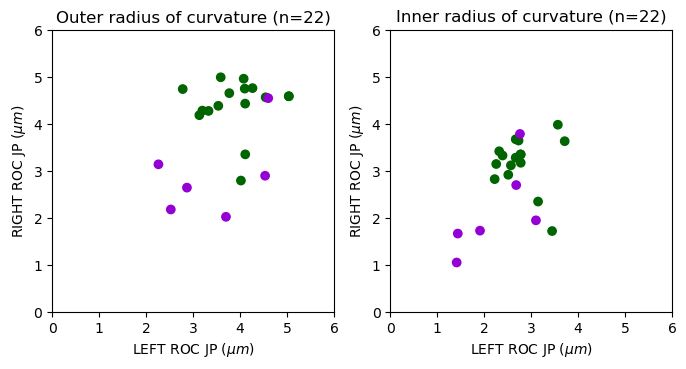

In [115]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

x = jp_left_in_r.loc[:, 'radii_out']
y = jp_right.loc[:, 'radii_out']
assert(all([i == j for i, j in zip(am_right.index, jp_right.index)]))
group_c = [om_group_color(c) for c in am_right.index]
ax[0].scatter(x, y, c=group_c)
ax[0].set_xlim([0.0, 6.0])
ax[0].set_ylim([0.0, 6.0])
ax[0].set_xlabel(r"LEFT ROC JP ($\mu m$)")
ax[0].set_ylabel(r"RIGHT ROC JP ($\mu m$)")
ax[0].set_aspect('equal')
ax[0].set_title(f'Outer radius of curvature (n={len(x)})')


x = jp_left_in_r.loc[:, 'radii_in']
y = jp_right.loc[:, 'radii_in']
ax[1].scatter(x, y, c=group_c)
ax[1].set_xlim([0.0, 6.0])
ax[1].set_ylim([0.0, 6.0])
ax[1].set_xlabel(r"LEFT ROC JP ($\mu m$)")
ax[1].set_ylabel(r"RIGHT ROC JP ($\mu m$)")
ax[1].set_aspect('equal')
ax[1].set_title(f'Inner radius of curvature (n={len(x)})')



Text(0, 0.5, 'RIGHT $(\\mu m)$')

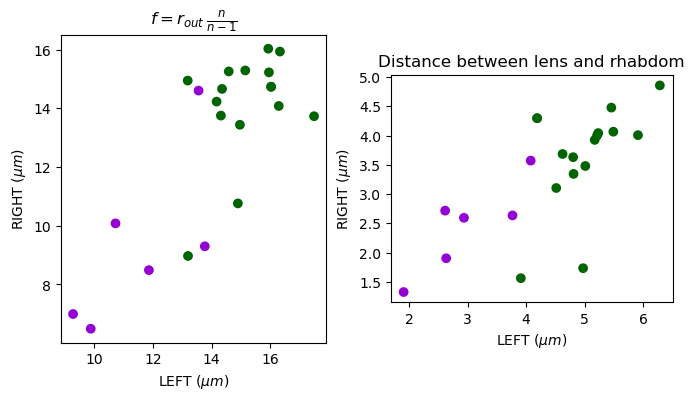

In [117]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

# Focal length
n = 1.452 # Refraction index of Apis lens 
f_thin = lambda r_outer: r_outer * n / (n-1)
f_left = f_thin(jp_left_in_r.loc[:, 'radii_out'])
f_jp = f_thin(jp_right.loc[:, 'radii_out'])

ax[0].scatter(f_am, f_jp, c=group_c)
ax[0].set_aspect('equal')
ax[0].set_title(r"$f = r_{out}\:\frac{n}{n-1}$")
ax[0].set_xlabel(r"LEFT $(\mu m)$")
ax[0].set_ylabel(f"RIGHT $(\mu m)$")

# Distance between lens and rhabdom
dist_am = jp_left_in_r.loc[:, 'distances']
dist_jp = jp_right.loc[:, 'distances']
ax[1].scatter(dist_am, dist_jp, c=group_c)
ax[1].set_aspect('equal')
ax[1].set_title(r"Distance between lens and rhabdom")
ax[1].set_xlabel(r"LEFT $(\mu m)$")
ax[1].set_ylabel(f"RIGHT $(\mu m)$")


## Correlation of focal length and distance between lens and rhabdom

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     14.16
Date:                Mon, 24 May 2021   Prob (F-statistic):            0.00122
Time:                        16:51:42   Log-Likelihood:                -41.725
No. Observations:                  22   AIC:                             87.45
Df Residuals:                      20   BIC:                             89.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8949      1.969      3.502      0.002       2.788      11.002
x1             1.7911      0.476      3.763      0.001       0.798       2.784
==============================================================================
Omnibus:                        0.445   Durbin-Watson:                   1.250
Prob(Omnibus):                  0.800   Jarque-Bera (JB):                0.027
Skew:                           0.082   Prob(JB):                        0.987
Kurtosis:                       3.046   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[6.89485295 1.79109437]


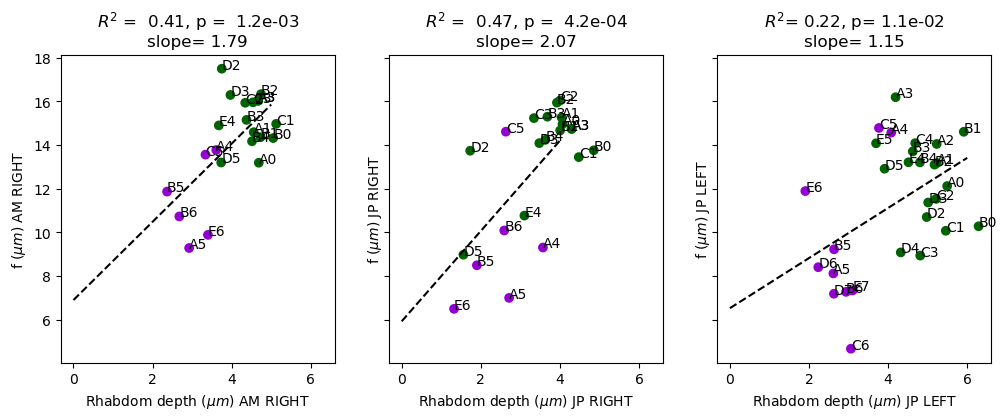

In [109]:


fig, ax = plt.subplots(1, 3, figsize=[12, 4], sharex=True, sharey=True)

n = 1.452 # Refraction index of Apis lens 
f_thin = lambda r_outer: r_outer * n / (n-1)

# ~~~~~~~~~~ AM RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in am_right.index]
for om, row in am_right.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['outer curvature']))
    d.append(row['cone length (from the tip)'])
    ax[0].annotate(om, (row['cone length (from the tip)'], f_thin(row['outer curvature'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(results.summary())
print(params)

ax[0].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[0].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[0].set_xlabel('Rhabdom depth ($\mu{m}$) AM RIGHT')
ax[0].set_ylabel("f ($\mu{m}$) AM RIGHT")

xx = np.arange(0, max(_x))
ax[0].plot(xx, params[1] * xx + params[0], c='k', ls='--')

# ~~~~~~~~~~ JP RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in jp_right.index]
for om, row in jp_right.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['radii_out']))
    d.append(row['distances'])
    ax[1].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[1].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[1].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[1].set_xlabel('Rhabdom depth ($\mu{m}$) JP RIGHT')
ax[1].set_ylabel("f ($\mu{m}$) JP RIGHT")

xx = np.arange(0, max(_x))
ax[1].plot(xx, params[1] * xx + params[0], c='k', ls='--')

# ~~~~~~~~~~ JP LEFT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in jp_left.index]
for om, row in jp_left.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['radii_out']))
    d.append(row['distances'])
    ax[2].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[2].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[2].set_title(f'$R^{2}$={results.rsquared: .2f}, p={results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax[2].set_xlabel('Rhabdom depth ($\mu{m}$) JP LEFT')
ax[2].set_ylabel("f ($\mu{m}$) JP LEFT")

xx = np.arange(0, max(_x))
ax[2].plot(xx, params[1] * xx + params[0], c='k', ls='--')


### Combine left and right

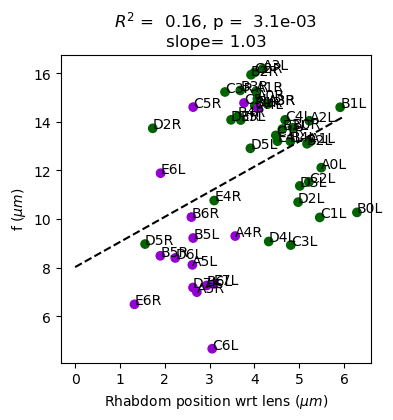

In [119]:
fig, ax = plt.subplots(1, figsize=[4, 4])

n = 1.452 # Refraction index of Apis lens 
f_thin = lambda r_outer: r_outer * n / (n-1)

# ~~~~~~~~~~ JP RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in jp_right.index]
for om, row in jp_right.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['radii_out']))
    d.append(row['distances'])
    ax.annotate(om + 'R', (row['distances'], f_thin(row['radii_out'])))
    

for om, row in jp_left.iterrows():  # replace with am_df to include C6
    f.append(f_thin(row['radii_out']))
    d.append(row['distances'])
    group_c.append(om_group_color(om))
    ax.annotate(om + 'L', (row['distances'], f_thin(row['radii_out'])))

_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax.scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p = {results.f_pvalue: .1e}\n' +
                f'slope={params[1]: .2f}')
ax.set_xlabel('Rhabdom position wrt lens ($\mu{m}$)')
ax.set_ylabel("f ($\mu{m}$)")

xx = np.arange(0, max(_x))
ax.plot(xx, params[1] * xx + params[0], c='k', ls='--')



Text(0, 0.5, 'f ($\\mu{m}$) JP LEFT')

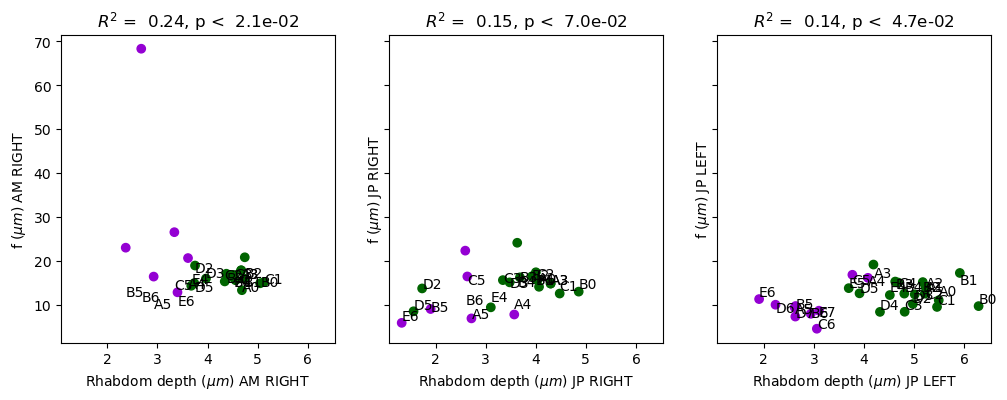

In [95]:
def lens_maker_thin(r1, r2):
    nl = 1.452 # lens
    nc = 1.348 # cone
    # lens power IN MICROMETERS
    p1 = (nl - 1.0)/r1 # interface air->lens 
    p2 = (nc - nl)/r2 # interface lens->cone
    p = p1 + p2
    # p3 = (t/nl)*p1*p2  # thickness 'correction'
    # p_thick = p1 + p2 - p3
    
    ### Focal length object and image (n/p) ###
    f = 1.0/(p)
    fi = nc/(p)
    return f

fig, ax = plt.subplots(1, 3, figsize=[12, 4], sharex=True, sharey=True)

# ~~~~~~~~~~ AM RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in am_right.index]
for om, row in am_right.iterrows():  # replace with am_df to include C6
    f.append(lens_maker_thin(row['outer curvature'], row['inner curvature']))
    d.append(row['cone length (from the tip)'])
    ax[0].annotate(om, (row['cone length (from the tip)'], f_thin(row['outer curvature'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[0].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[0].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax[0].set_xlabel('Rhabdom depth ($\mu{m}$) AM RIGHT')
ax[0].set_ylabel("f ($\mu{m}$) AM RIGHT")

# ~~~~~~~~~~ JP RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in jp_right.index]
for om, row in jp_right.iterrows():  # replace with am_df to include C6
    f.append(lens_maker_thin(row['radii_out'], row['radii_in']))
    d.append(row['distances'])
    ax[1].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[1].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[1].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax[1].set_xlabel('Rhabdom depth ($\mu{m}$) JP RIGHT')
ax[1].set_ylabel("f ($\mu{m}$) JP RIGHT")

# ~~~~~~~~~~ JP LEFT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in jp_left.index]
for om, row in jp_left.iterrows():  # replace with am_df to include C6
    f.append(lens_maker_thin(row['radii_out'], row['radii_in']))
    d.append(row['distances'])
    ax[2].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[2].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[2].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax[2].set_xlabel('Rhabdom depth ($\mu{m}$) JP LEFT')
ax[2].set_ylabel("f ($\mu{m}$) JP LEFT")


Text(0, 0.5, 'f ($\\mu{m}$) JP LEFT')

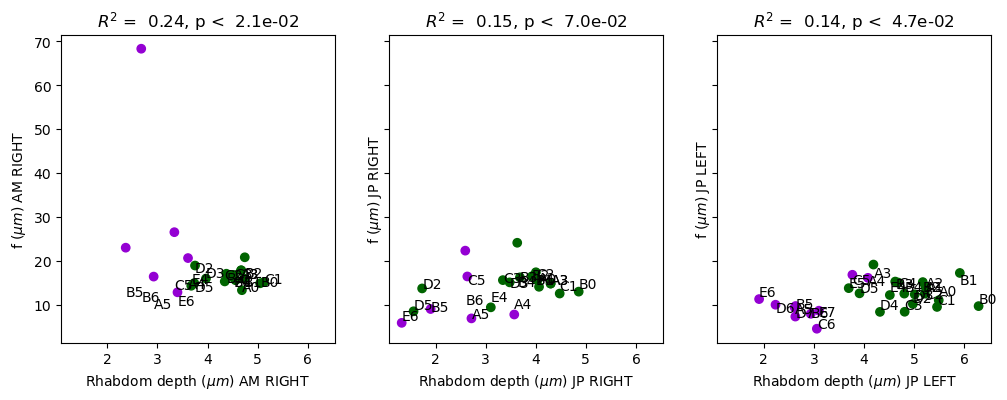

In [111]:
def lens_maker_thick(r1, r2, t):
    nl = 1.452 # lens
    nc = 1.348 # cone
    # lens power IN MICROMETERS
    p1 = (nl - 1.0)/r1 # interface air->lens 
    p2 = (nc - nl)/r2 # interface lens->cone
    p3 = (t/nl)*p1*p2  # thickness 'correction'
    p = p1 + p2 - p3
    
    ### Focal length object and image (n/p) ###
    f = 1.0/(p)
    fi = nc/(p)
    return f

fig, ax = plt.subplots(1, 3, figsize=[12, 4], sharex=True, sharey=True)

# ~~~~~~~~~~ AM RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in am_right.index]
for om, row in am_right.iterrows():  # replace with am_df to include C6
    f.append(lens_maker_thin(row['outer curvature'], row['inner curvature']))
    d.append(row['cone length (from the tip)'])
    ax[0].annotate(om, (row['cone length (from the tip)'], f_thin(row['outer curvature'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[0].scatter(x=_x, y=Y, marker='o', c=group_c)
ax[0].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax[0].set_xlabel('Rhabdom depth ($\mu{m}$) AM RIGHT')
ax[0].set_ylabel("f ($\mu{m}$) AM RIGHT")

# ~~~~~~~~~~ JP RIGHT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in jp_right.index]
for om, row in jp_right.iterrows():  # replace with am_df to include C6
    f.append(lens_maker_thin(row['radii_out'], row['radii_in']))
    d.append(row['distances'])
    ax[1].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[1].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[1].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax[1].set_xlabel('Rhabdom depth ($\mu{m}$) JP RIGHT')
ax[1].set_ylabel("f ($\mu{m}$) JP RIGHT")

# ~~~~~~~~~~ JP LEFT ~~~~~~~~~~~~
f = []
d = []
group_c = [om_group_color(c) for c in jp_left.index]
for om, row in jp_left.iterrows():  # replace with am_df to include C6
    f.append(lens_maker_thin(row['radii_out'], row['radii_in']))
    d.append(row['distances'])
    ax[2].annotate(om, (row['distances'], f_thin(row['radii_out'])))
_x = d
X = sm.add_constant(_x)
Y = f

model = sm.OLS(Y, X)
results = model.fit()
params = results.params

ax[2].scatter(x=_x, y=Y, marker='o', c=group_c)
#ax[1].annotate(jp_right.index, (_x, Y))
ax[2].set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax[2].set_xlabel('Rhabdom depth ($\mu{m}$) JP LEFT')
ax[2].set_ylabel("f ($\mu{m}$) JP LEFT")


Text(0, 0.5, 'Right eye: ROC, micron (AM)')

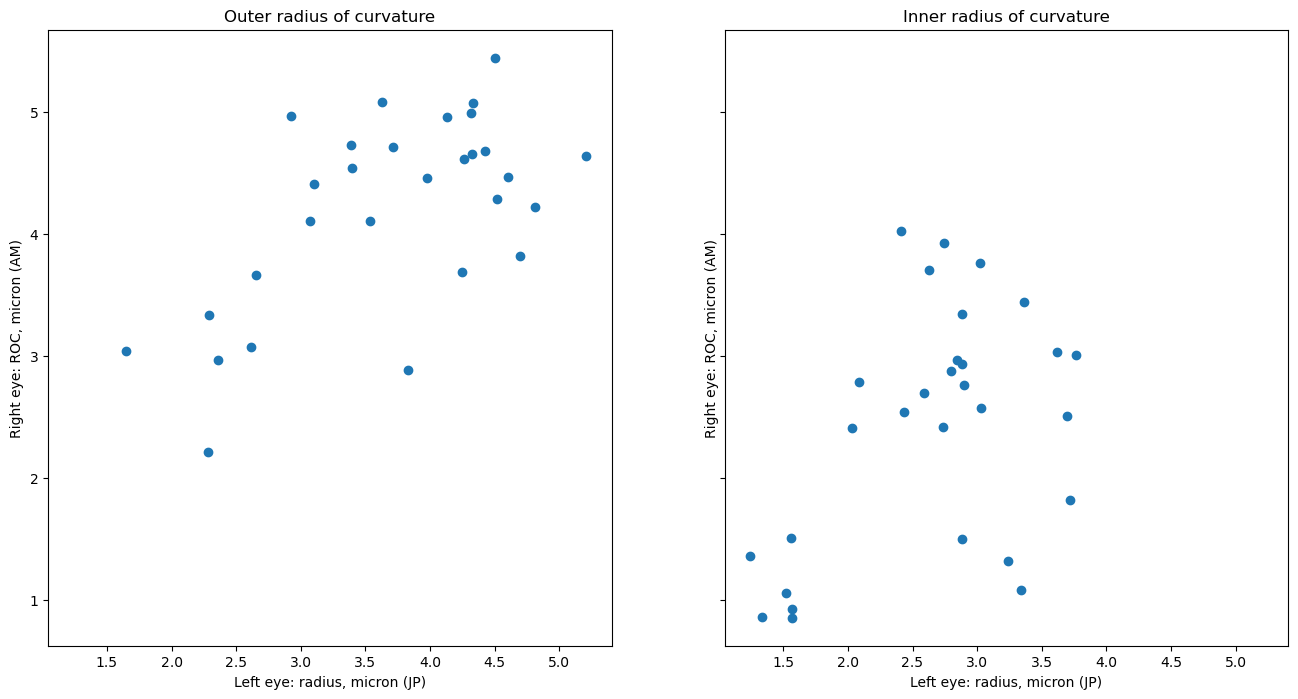

In [94]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[16, 8])

ax[0].scatter(optics_df['left_outer_curve'], optics_df['outer curvature'])
ax[1].scatter(optics_df['left_inner_curve'], optics_df['inner curvature'])

ax[0].set_title('Outer radius of curvature')
ax[1].set_title('Inner radius of curvature')

ax[0].set_xlabel('Left eye: radius, micron (JP)')
ax[1].set_xlabel('Left eye: radius, micron (JP)')

ax[0].set_ylabel('Right eye: ROC, micron (AM)')
ax[1].set_ylabel('Right eye: ROC, micron (AM)')

In [108]:
#### OUTER ####
### LEFT EYE (JP) ###
display(optics_df['left_outer_curve'].mean())
display(optics_df['left_outer_curve'].std(ddof=0))
display(optics_df['left_outer_curve'].std(ddof=0)/optics_df['left_outer_curve'].mean())
### RIGHT EYE (AM) ###
display(optics_df['outer curvature'].mean())
display(optics_df['outer curvature'].std(ddof=0))
display(optics_df['outer curvature'].std(ddof=0)/optics_df['outer curvature'].mean())


3.6831572274593167

0.8922485023735048

0.2422509948045275

4.201835517241379

0.7822177267760763

0.18616095836364957

In [109]:
#### INNER ####
### LEFT EYE (JP) ###
display(optics_df['left_inner_curve'].mean())
display(optics_df['left_inner_curve'].std(ddof=0))
display(optics_df['left_inner_curve'].std(ddof=0)/optics_df['left_inner_curve'].mean())
### RIGHT EYE (AM) ###
display(optics_df['inner curvature'].mean())
display(optics_df['inner curvature'].std(ddof=0))
display(optics_df['inner curvature'].std(ddof=0)/optics_df['inner curvature'].mean())


2.6353247673257636

0.7346780292501046

0.27878083125049913

2.4161949655172412

0.9685264418256642

0.40084780228748185

In [124]:
optics_df.filter(like='curv').loc[['E7', 'E5', 'D7', 'D6', 'D4', 'C4'], 
                                  ['left_outer_curve', 'outer curvature', 'left_inner_curve', 'inner curvature']]

,left_outer_curve,outer curvature,left_inner_curve,inner curvature
E7,2.279118,2.219,1.518529,1.059
E5,4.696234,3.818,2.896222,2.765
D7,2.361009,2.969,1.567978,0.926
D6,1.647444,3.042,1.243092,1.363
D4,4.265905,4.619,3.694454,2.510
C4,4.424166,4.677,3.026345,2.577


Text(0, 0.5, 'Right eye: ROC, micron (AM)')

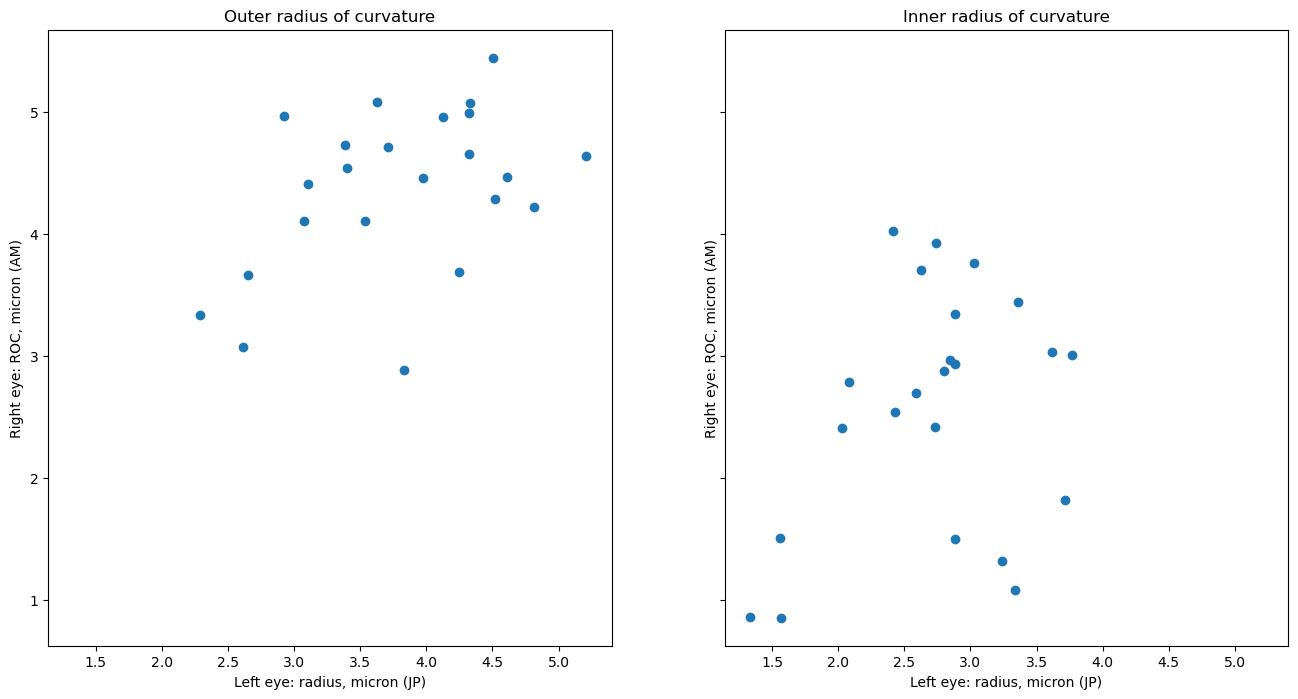

In [125]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[16, 8])

data = optics_df.loc[[i for i in optics_df.index if i not in ['E7', 'E5', 'D7', 'D6', 'D4', 'C4']]]

ax[0].scatter(data['left_outer_curve'], data['outer curvature'])
ax[1].scatter(data['left_inner_curve'], data['inner curvature'])

ax[0].set_title('Outer radius of curvature')
ax[1].set_title('Inner radius of curvature')

ax[0].set_xlabel('Left eye: radius, micron (JP)')
ax[1].set_xlabel('Left eye: radius, micron (JP)')

ax[0].set_ylabel('Right eye: ROC, micron (AM)')
ax[1].set_ylabel('Right eye: ROC, micron (AM)')